# OpenCL application walkthrough - Matrix Multiplication

Often it is helpful to see a complete example that is fully explained in every detail. Matrix multiplication is a commonly employed compute operation and we can use it for a complete example with OpenCL. The  multiplication of matrices **A** and **B** proceeds by taking the dot product between every row **i0** in matrix **A** and every column **i1** of matrix **B**. If we multiply (elementwise) a row **i0** of matrix **A** by a column **i1** of Matrix B, then the dot product is the sum of the multiplied elements. The result of each dot product is then the value at position (i0,i1) in matrix **C**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C.</figcaption>
</figure>


The strategy we use here is to associate a kernel with every point (m,n) in Matrix C. This means the Grid for this problem must be large enough to cover the entire size of Matrix C. Every kernel will compute its own dot product. The source code for the example is in [mat_mult.cpp](mat_mult.cpp). Click on the link and open up the file in a different window.

## Running the example program

We first run the application then understand how it works.

### Write out the matrices

The first step is to generate some matrices **A** and **B** for use by the program.

In [7]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 256
NROWS_C = 520
NCOLS_C = 1032

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")

### Compile and run the program

In [8]:
!make clean; make; ./mat_mult.exe

rm -r *.exe
g++ -std=c++11 -g -O2 -fopenmp -I/usr/local/cuda/include -I../include -L/usr/local/cuda/lib64 mat_mult.cpp\
	-o mat_mult.exe -lOpenCL -lomp
In file included from ../include/cl_helper.hpp:10,
                 from mat_mult.cpp:16:
/usr/local/cuda/include/CL/cl.hpp:5085:28: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
 5085 |         VECTOR_CLASS<cl_int>* binaryStatus = NULL,
      |                            ^
In file included from mat_mult.cpp:16:
../include/cl_helper.hpp:16:29: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
   16 | std::map<cl_int, const char*> error_codes {
      |                             ^
g++ -std=c++11 -g -O2 -fopenmp -I/usr/local/cuda/include -I../include -L/usr/local/c

### Read in the answer and verify results

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
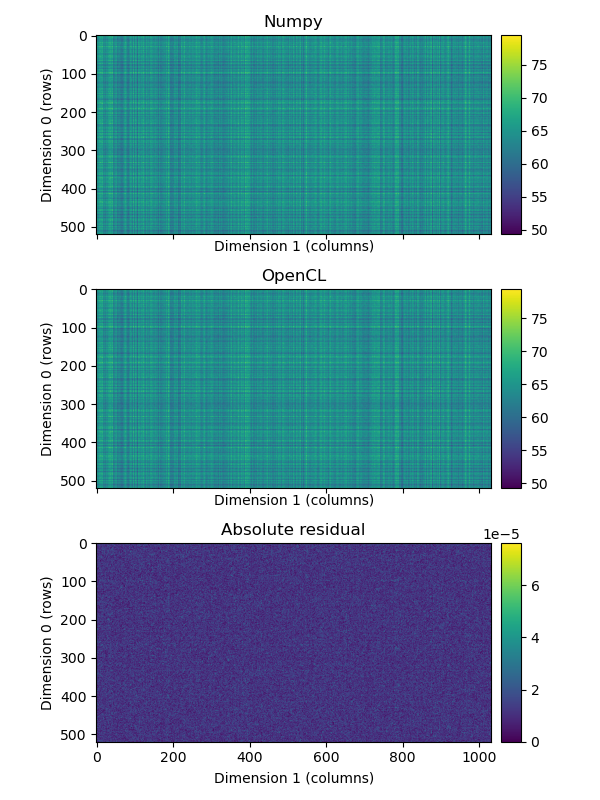

In [9]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

## The example program - line by line

As covered in the Introduction, every accelerated application follows the same logical progression of steps: 

1. Compute resources discovered
1. Kernels prepared for compute devices
1. Memory allocated on the compute device
1. Memory copied to the compute device
1. Kernels run on the compute device
1. Wait for kernels to finish
1. Memory copied back from the computed device to the host
1. Repeat steps 3 - 8 as many times as necessary
1. Clean up resources and exit

For the matrix multiplication problem with OpenCL we have chosen the following strategy:

1. Discover resources
1. Allocate command queues and choose a compute device
1. Read in matrices **A** and **B** from file into host memory
1. Allocate OpenCL Buffers for arrays **A**, **B**, and **C** on the compute device
1. Build the program from source for the chosen compute device
1. Set kernel arguments
1. Upload matrices **A** and **B** from the host to their corresponding OpenCL device Buffers
1. Run the kernel to compute **C** from **A** and **B**
1. Copy the Buffer for matrix **C** back to the host
1. Write the contents of matrix **C** to disk
1. Clean up arrays and release resources

We will now walk through every step in the sequence and explain how everything is working in as much depth as is practical. OpenCL applications have a fair bit of tedious boilerplate code, and just about every OpenCL application uses some form of home-grown header files to shield the programmer from extra complexity and a potential source of errors. The applications covered in this course are no different. We will explain what each helper function does and how it fits into the rest of the program. It is helpful to have the source code [mat_mult.cpp](mat_mult.cpp) open while we traverse the code.

### Header files

After some essential includes, we include our helper headers. In this instance the header **cl_helper.hpp** is located in the **course_material/include** directory. Open the file by clicking on this link to <a href="../include/cl_helper.hpp">cl_helper.hpp</a>.

```C++
// mat_mult.cpp source

// Bring in helper header to manage boilerplate code
#include "cl_helper.hpp"
```

The first thing that the header does is to include the headers for the OpenCL C library. If we open that file in the browser we see the code

```C++
// mat_mult.cpp source

#ifdef __APPLE__
    #include "OpenCL/opencl.h"
#else
    #include "CL/cl.hpp"
#endif
```

On MacOS, the header files for the OpenCL ICD loader are located in **OpenCL/opencl.h**, whereas on every other system they are in **CL/cl.hpp**. This is why we need a MacOS-specific **#ifdef**.

### Sanity checking OpenCL function calls

Every call to an OpenCL function has some way of validating wether or not it worked. The return code for each call is in the form of an OpenCL integer datatype **cl_int**, which guarantees a signed integer with exactly 32 bits. For more information on OpenCL datatypes click <a href="../Reference_notes/OpenCL_datatypes.ipynb">here</a> or consult the the latest [OpenCL C specification](https://www.khronos.org/registry/OpenCL/specs/3.0-unified/pdf/OpenCL_C.pdf).

The standard defines a number of of error codes, **CL_SUCCESS** is the universal OpenCL code for a successful function call, and the **error_codes** lookup table in **cl_helper.hpp** provides a mapping from error code integers to names.

It is **good practice** to always check the return code of each OpenCL call and adequately handle each return code. Otherwise OpenCL programs can fail silently and lead to undefined behaviour. The helper function **h_errchk** takes in an error code and a message and prints an error and exits if it encounters any error code other than **CL_SUCCESS**.

```C++
// cl_helper.hpp source

// Function to check error code
void h_errchk(cl_int errcode, const char *message) {
    if (errcode!=CL_SUCCESS) {
        // Is the error code in the map
        if (error_codes.count(errcode)>0) {
            std::printf("Error, Opencl call failed at \"%s\" with error code %s (%d)\n", 
                    message, error_codes[errcode], errcode);
        } else {
            // We don't know how to handle the error code, so just print it
            std::printf("Error, OpenCL call failed at \"%s\" with error code %d\n", 
                    message, errcode);
        }
        // We have failed one way or the other, so just exit
        exit(OCL_EXIT);
    }
};
```

Within the main program [mat_mul.cpp](mat_mul.cpp) we declare the variable **errcode** to handle the output from programs.

```C++
// mat_mult.cpp source

// Useful for checking OpenCL errors
cl_int errcode;
```

Checking the errorcode for any function call is then a matter of calling the **h_errchk** function, like this:

```C++
// Example usage of h_errchk
h_errchk(errcode, "checking the example function");
```

If **errcode** is anything other than **CL_SUCCESS**, then the function will crash the program and spit out what the error code is. The [OpenCL Specification](https://www.khronos.org/registry/OpenCL/specs/3.0-unified/pdf/OpenCL_API.pdf) has a list of error codes and what they mean.

### Resource discovery

Remember from the <a href="../L1_Introduction/L1 - Introduction.ipynb">Introduction</a> that Buffers are allocated within **contexts** and **command queues** need both contexts and devices. During the process of resource discovery, we need to: 

1. Locate the platforms, 
2. Select compatible devices (CPU's, GPU's etc) in each platform
3. Construct a Context for every device found

<figure style="margin-left:auto; margin-right:auto; width:50%;">
    <img style="vertical-
                align:middle" src="../images/opencl_components_discovery.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Picking  platforms, discovering devices, and creating contexts.</figcaption>
</figure>

It is most flexible and portable if we associate a single context with every device discovered. The following code defines some pointers that will point to allocations of platforms, devices, and contexts. It also defines some variables to store the number of platforms and devices. 

```C++
    // mat_mult.cpp source

    // Create handles to platforms, 
    // devices, and contexts

    // Create handles to platforms, 
    // devices, and contexts

    // Number of platforms discovered
    cl_uint num_platforms;

    // Number of devices discovered
    cl_uint num_devices;

    // Pointer to an array of platforms
    cl_platform_id *platforms = NULL;

    // Pointer to an array of devices
    cl_device_id *devices = NULL;

    // Pointer to an array of contexts
    cl_context *contexts = NULL;
```

The variable **target_device** decides which kind of devices we wish to use. It is of type **cl_device_type** and there are three common choices:


| cl_device_type | explanation |  
| :- | :- | 
| CL_DEVICE_TYPE_ALL | get every OpenCL device
| CL_DEVICE_TYPE_GPU | get only GPU devices
| CL_DEVICE_TYPE_CPU | get only CPU devices

We choose the **CL_DEVICE_TYPE_ALL** type to get all possible OpenCL devices on the system. 

```C++
    // Discover platforms and devices
    // and create contexts
    cl_device_type target_device=CL_DEVICE_TYPE_ALL;
```

A helper function called **h_acquire_devices** goes through the process of resource discovery and fills the contents of these variables.

```C++
// mat_mult.cpp source

// Helper function to acquire devices
h_acquire_devices(target_device,
                 &platforms,
                 &num_platforms,
                 &devices,
                 &num_devices,
                 &contexts);
```

#### Examining **h_acquire_devices** in depth

We now examine the function **h_acquire_devices**, whose source code is in <a href="../include/cl_helper.hpp">cl_helper.hpp</a>. Every OpenCL platform has a set of zero or more devices that fit the description of the target device. What this function does is to query all of the platforms and discover available OpenCL devices that meet the description of the target device. All compatible devices found are then placed into a flat array of type **cl_device** that has been allocated to fit. At the same time an array of type **cl_context** is created with the same number of elements as that of the devices array.

The function **[clGetPlatformIDs](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetPlatformIDs.html)** is OpenCL's way of working with platforms. It has two modes, depending on the input arguments:

* Query the number of platforms
* Fill an allocated array with the number of platforms found

In the first bit of the code we use **clGetPlatformIDs** to locate the number of OpenCL platforms, allocate memory for the platforms, then call **clGetPlatformIDs** again to fill the platforms.

```C++
// cl_helper.hpp source

// Function to create lists of contexts and devices that map to available hardware
void h_acquire_devices(
        // Input parameter
        cl_device_type device_type,
        // Output parameters
        cl_platform_id **platform_ids_out,
        cl_uint *num_platforms_out,
        cl_device_id **device_ids_out,
        cl_uint *num_devices_out, 
        cl_context **contexts_out) {

    // Return code for running things
    cl_int ret_code = CL_SUCCESS;
    
    //// Get all valid platforms ////
    cl_uint num_platforms; 
    cl_platform_id *platform_ids = NULL;
    
    // First call to clGetPlatformIDs - get the number of platforms
    h_errchk(clGetPlatformIDs(0, NULL, &num_platforms), "Fetching number of platforms");
    
    // Allocate memory for platform id's
    platform_ids = (cl_platform_id*)calloc(num_platforms, sizeof(cl_platform_id));
    
    // Second call to clGetPlatformIDs - fill the platforms
    h_errchk(clGetPlatformIDs(num_platforms, platform_ids, NULL), "Fetching platforms");
```

Similarly, the function **[clGetDeviceIDs](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetDeviceIDs.html)** has two modes depending on the input arguments:

* Determine the number of devices in a platform
* Fill an allocated array with devices found in a platform

We iterate over every platform found and use **clGetDeviceIDs** to query the number of compatible OpenCL devices. We quit the program if no devices meet the **device_type** selection criteria. 

```C++
    // Fetch the total number of compatible devices
    cl_uint num_devices=0;
    
    // Loop over each platform and get the total number
    // of devices that match device_type
    for (cl_uint n=0; n < num_platforms; n++) {
        // Temporary number of devices
        cl_uint ndevs;
        // Get number of devices in the platform
        ret_code = clGetDeviceIDs(
            platform_ids[n],
            device_type,
            0,
            NULL,
            &ndevs);

        if (ret_code != CL_DEVICE_NOT_FOUND) {
            h_errchk(ret_code, "Getting number of devices");
            num_devices += ndevs;
        }
    }
    
    // Check to make sure we have more than one suitable device
    if (num_devices == 0) {
        std::printf("Failed to find a suitable compute device\n");
        exit(OCL_EXIT);
    }
```

Next we allocate arrays **device_ids** and **contexts** for devices and contexts. Each array has the same number of elements because we allocate a context for each device found. 

```C++
    // Allocate flat 1D allocations for device ID's and contexts,
    // both allocations have the same number of elements
    cl_device_id *device_ids = (cl_device_id*)calloc(num_devices, sizeof(cl_device_id));
    cl_context *contexts = (cl_context*)calloc(num_devices, sizeof(cl_context));
```

For every platform, the function **clGetDeviceIDs** is called again to fill the **device_ids** array with compatible devices. Then for every compatible device the [clCreateContext](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateContext.html) function is used to create a context and fill an element of the **contexts** array.


```C++
    // Temporary pointers
    cl_device_id *device_ids_ptr = device_ids;
    cl_context *contexts_ptr = contexts;
    
    // Now loop over platforms and fill device ID's array
    for (cl_uint n=0; n < num_platforms; n++) {
        // Temporary number of devices
        cl_uint ndevs;

        // Get the number of devices in a platform
        ret_code = clGetDeviceIDs(
            platform_ids[n],
            device_type,
            0,
            NULL,
            &ndevs);

        if (ret_code != CL_DEVICE_NOT_FOUND) {
            // Check to see if any other error was generated
            h_errchk(ret_code, "Getting number of devices for the platform");
            
            // Fill the array with the next set of found devices
            h_errchk(clGetDeviceIDs(
                platform_ids[n],
                device_type,
                ndevs,
                device_ids_ptr,
                NULL), "Filling devices");
            
            // Create a context for every device found
            for (cl_uint c=0; c<ndevs; c++ ) {
                // Context properties, this can be tricky
                const cl_context_properties prop[] = { CL_CONTEXT_PLATFORM, 
                                                      (cl_context_properties)platform_ids[n], 
                                                      0 };
                
                // Create a context with 1 device in it
                const cl_device_id dev_id = device_ids_ptr[c];
                cl_uint ndev = 1;
                
                // Fill the contexts array at this point 
                // with a newly created context
                *contexts_ptr = clCreateContext(
                    prop, 
                    ndev, 
                    &dev_id,
                    NULL,
                    NULL,
                    &ret_code
                );
                h_errchk(ret_code, "Creating a context");
                contexts_ptr++;
            }
            
            // Advance device_id's pointer 
            // by the number of devices discovered
            device_ids_ptr += ndevs;
        }
    }   

    // Fill in output information here to 
    // avoid problems with understanding
    *platform_ids_out = platform_ids;
    *num_platforms_out = num_platforms;
    *device_ids_out = device_ids;
    *num_devices_out = num_devices;
    *contexts_out = contexts;
}
```

### Command queues

Every bit of OpenCL work sent to a device, either to copy data or to execute a kernel, needs a command queue. A command queue is to be thought of as a place where work is sent to a device. 

<figure style="margin-left:auto; margin-right:auto; width:50%;">
    <img style="vertical-
                align:middle" src="../images/opencl_components_command_queues.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Creating command queues.</figcaption>
</figure>

There are two flavours of command queues, **In-order** and **out-of-order**. For **in-order** command queues, commands are executed in the order that they are submitted. The first bit of work to be queued is the first bit of work executed. With **out-of-order** command queues, commands may be executed in any order. Furthermore, with command queues there is the ability to profile or otherwise keep track of commands being sent.

In the example code we create command queues with the aid of a helper function called **h_create_command_queues**. We call the function like this:

```C++
    // mat_mult.cpp source

    // Number of command queues to generate
    cl_uint num_command_queues = num_devices;

    // Do we enable out-of-order execution 
    cl_bool ordering = CL_FALSE;
    
    // Do we enable profiling?
    cl_bool profiling = CL_FALSE;
    
    // Create the command queues
    cl_command_queue* command_queues = h_create_command_queues(
        devices,
        contexts,
        num_devices,
        num_command_queues,
        ordering,
        profiling
    );
```

#### Examining **h_create_command_queues** in depth

The code for **h_create_command_queues** is located in <a href="../include/cl_helper.hpp">cl_helper.hpp</a>. Given arrays of device_id's and contexts, the function creates as many command queues as desired, using a Round-Robin strategy over the available compute devices. It is largely implementation-specific as to how many command queues are permitted per device, therefore it is **good practice** to **limit** the number of command queues to some small multiple of the number of available compute devices. In this case we have set the number of desired command queues equal to the number of available devices.

```C++
// cl_helper.hpp source

// Function to create command queues
cl_command_queue* h_create_command_queues(
        // Create a list of command queues
        // with selectable properties
        // Assumes that contexts is as long as devices
        
        // Array of OpenCL device id's
        cl_device_id *devices,
        // Array of OpenCL contexts
        cl_context *contexts,
        // How long is devices and contexts?
        cl_uint num_devices,
        // How many command queues should we create?
        cl_uint num_command_queues,
        // Do we enable out-of-order execution?
        cl_bool out_of_order_enable,
        // Do we enable profiling of commands 
        // sent to the command queues
        cl_bool profiling_enable) {
    
    // Return code for error checking
    cl_int ret_code;   
```
    
The choice of wether or not a command queue is in-order or out-of-order is accomplished through the **cl_command_queue_properties** type, which is a bit field where the 1's in certain bit positions have meaning. Therefore we use binary OR operations to build up the bit-field in **queue_propeties**.
    
```C++
    
    // Manage bit fields for the command queue properties
    cl_command_queue_properties queue_properties = 0;
    if (out_of_order_enable == CL_TRUE) {
        queue_properties = queue_properties | CL_QUEUE_OUT_OF_ORDER_EXEC_MODE_ENABLE;    
    }
    if (profiling_enable == CL_TRUE) {
        queue_properties = queue_properties | CL_QUEUE_PROFILING_ENABLE;    
    }

    // Allocate memory for the command queues
    cl_command_queue *command_queues = (cl_command_queue*)calloc(num_command_queues, sizeof(cl_command_queue));
```

Now that command queues have been allocated, we use [clCreateCommandQueue](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateCommandQueue.html) to create a command queue with the desired properties.

```C++
    // Fill command queues in a Round-Robin fashion
    for (cl_uint n=0; n<num_command_queues; n++) {
        command_queues[n] = clCreateCommandQueue(
            contexts[n % num_devices],
            devices[n % num_devices],
            queue_properties,
            &ret_code    
        );
        h_errchk(ret_code, "Creating a command queue");        
    }
            
    return command_queues;
}
```

### Compute device selection

We only need one compute device for this application. The simplest strategy is to just pick the first available command queue, device and context. The selected command queue, device, and context must of course be consistent with each other.

```C++
    // mat_mult.cpp source

    // Choose the first available context 
    // and compute device to use
    cl_uint dev_index = 0;
    cl_context context = contexts[dev_index];
    cl_command_queue command_queue = command_queues[dev_index];
    cl_device_id device = devices[dev_index];
```

### Compute device capabilities

OpenCL implementations place limits on the abilities of each compute device, such as the number of work items that can exist in a workgroup, or the maximum size of a global memory allocation. Sometimes it is necessary to explore these limits. In this instance we call a helper function called **h_report_on_device** in <a href="../include/cl_helper.hpp">cl_helper.hpp</a> that reports on the name, global memory size, largest possible buffer size, maximum extent  of workgroups along each dimension, and maximum number of work-items in a workgroup.
```C++
    // mat_mult.cpp source

    // Report on the device in use
    h_report_on_device(device);
```

#### Examining **h_report_on_device** in depth

Below is the code for the function **h_report_on_device**. Given an OpenCL device, the function [clGetDeviceInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetDeviceInfo.html) allows us to retrieve information on device capabilities. As with other OpenCL functions the function has two modes of being called. The first mode fetches information on the size of the data being retrieved so one can make the proper allocations. The second mode fetches the actual information. An OpenCL defined constant (such as CL_DEVICE_NAME) determines what information is being retrieved. The man page for [clGetDeviceInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetDeviceInfo.html) shows a list of what data may be retrieved from the device.

```C++
// cl_helper.hpp source

// Function to report information on a compute device
void h_report_on_device(cl_device_id device) {
    // Report some information on the device
    
    // Fetch the name of the compute device
    size_t nbytes_name;
    
    // First call is to fetch 
    // the number of bytes taken up by the name
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_NAME, 
                        0, 
                        NULL, 
                        &nbytes_name),
        "Device name bytes"
    );
    // Allocate memory for the name
    char* name=new char[nbytes_name+1];
    // Don't forget the NULL character terminator
    name[nbytes_name] = '\0';
    // Second call is to fill the allocated name
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_NAME, 
                        nbytes_name, 
                        name, 
                        NULL),
        "Device name"
    );
    std::printf("\t%20s %s \n","name:", name);

    // Fetch the global memory size
    cl_ulong mem_size;
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_GLOBAL_MEM_SIZE, 
                        sizeof(cl_ulong), 
                        &mem_size, 
                        NULL),
        "Global mem size"
    );
    std::printf("\t%20s %llu MB\n","global memory size:",mem_size/(1000000));
    
    // Fetch the maximum size of a global memory allocation
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_MAX_MEM_ALLOC_SIZE, 
                        sizeof(cl_ulong), 
                        &mem_size, 
                        NULL),
        "Max mem alloc size"
    );
    std::printf("\t%20s %llu MB\n","max buffer size:", mem_size/(1000000));
    
    // Get the maximum number of dimensions supported
    cl_uint max_work_dims;
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_MAX_WORK_ITEM_DIMENSIONS, 
                        sizeof(cl_uint), 
                        &max_work_dims, 
                        NULL),
        "Max number of dimensions for local size."
    );
    
    // Get the max number of work items along
    // dimensions of a work group
    size_t* max_size = new size_t[max_work_dims];
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_MAX_WORK_ITEM_SIZES, 
                        max_work_dims*sizeof(size_t), 
                        max_size, 
                        NULL),
        "Max size for work items."
    );
    
    // Print out the maximum extent of 
    // items in a workgroup
    std::printf("\t%20s (", "max local size:");
    for (int n=0; n<max_work_dims-1; n++) {
        std::printf("%zu,", max_size[n]);
    }
    std::printf("%zu)\n", max_size[max_work_dims-1]);
    
    // Get the maximum number of work items in a work group
    size_t max_work_group_size;
    h_errchk(
        clGetDeviceInfo(device, 
                        CL_DEVICE_MAX_WORK_GROUP_SIZE, 
                        sizeof(size_t), 
                        &max_work_group_size, 
                        NULL),
        "Max number of work-items a workgroup."
    );
    std::printf("\t%20s %zu\n", "max work-items:", max_work_group_size);
    
    // Clean up
    delete [] max_size;
    delete [] name;
}
```

### Reading matrices from disk

This isn't an OpenCL task, but we need the matrices **A** and **B** read into memory before creating device Buffers. A helper function called **h_read_binary** is employed to open a binary file, determine it's size, create a memory allocation and read the contents of the file directly into it.

```C++
    // mat_mult.cpp source

    cl_uint N1_A = NCOLS_A, N0_C = NROWS_C, N1_C = NCOLS_C;
    size_t nbytes_A, nbytes_B, nbytes_C;

    // Read the input data into arrays and sanity check
    cl_float* array_A = (cl_float*)h_read_binary("array_A.dat", &nbytes_A);
    cl_float* array_B = (cl_float*)h_read_binary("array_B.dat", &nbytes_B);
```
Do some brief sanity checking to make sure the file is as big as we think it is.
```C++
    // Sanity check on incoming data
    assert(nbytes_A==N0_C*N1_A*sizeof(cl_float));   
    assert(nbytes_B==N1_A*N1_C*sizeof(cl_float));
    nbytes_C=N0_C*N1_C*sizeof(cl_float);
```

If we look at the source code for **h_read_binary** in <a href="../include/cl_helper.hpp">cl_helper.hpp</a>, the **fseek**, **ftell**, and **rewind**, functions are used to determine the size of the file before using **fread** to read the file into a memory allocation. 

```C++
// cl_helper.hpp source

void* h_read_binary(const char* filename, size_t *nbytes) {
    // Open the file for reading and use std::fread to read in the file
    std::FILE *fp = std::fopen(filename, "rb");
    if (fp == NULL) {
        std::printf("Error in reading file %s", filename);
        exit(OCL_EXIT);
    }
    
    // Seek to the end of the file
    std::fseek(fp, 0, SEEK_END);
    
    // Extract the number of bytes in this file
    *nbytes = std::ftell(fp);

    // Rewind the file pointer
    rewind(fp);
```
In the event that the file being read is a string we add an extra termination character at the end of the allocation.
```C++
    // Create a buffer to read into
    // Add an extra Byte for a null termination character
    // just in case we are reading to a string
    void *buffer = calloc((*nbytes)+1, 1);
    
    // Set the NULL termination character
    char* source = (char*)buffer;
    source[*nbytes] = '\0';
    
    // Read the file into the buffer and close
    std::fread(buffer, 1, *nbytes, fp);
    std::fclose(fp);
    return buffer;
}
```

### Device buffer creation

With a context in hand we are now in a position to create Buffers for storing matrices **A**, **B** and **C** on the compute device. 

<figure style="margin-left:auto; margin-right:auto; width:50%;">
    <img style="vertical-
                align:middle" src="../images/opencl_components_buffers.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Creating Buffers within a Context.</figcaption>
</figure>


The function [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) provides a number of options for creating Buffers, and we will explore those in a later lesson. For now we use a straightforward read-write buffer, selected with the option CL_MEM_READ_WRITE.

```C++
    // mat_mult.cpp source

    // Make Buffers on the compute device 
    cl_mem buffer_A = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE, 
                                     nbytes_A, 
                                     NULL, 
                                     &errcode);
    h_errchk(errcode, "Creating buffer_A");
    
    cl_mem buffer_B = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE, 
                                     nbytes_B, 
                                     NULL, 
                                     &errcode);
    h_errchk(errcode, "Creating buffer_B");
    
    cl_mem buffer_C = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE, 
                                     nbytes_C, 
                                     NULL, 
                                     &errcode);
    h_errchk(errcode, "Creating buffer_C");
```

### Kernel compilation

Every kernel that runs on a compute device **must be compiled** for that device. 

<figure style="margin-left:auto; margin-right:auto; width:50%;">
    <img style="vertical-
                align:middle" src="../images/opencl_components_kernels.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Compiling kernels for devices in a Context.</figcaption>
</figure>

How it works is that kernel source code is brought into the host program either as a string, array of strings, or a precompiled binary. The source for one or more kernels is compiled into a **program**, and a kernel can be created from the compiled program. 

Including kernel code directly in the host program source is a security risk if the protection of intellectual property is important. An attacker can simply open the compiled program in a text editor and peek at the kernel source as compiled ASCI characters! If you need to protect kernel intellectual property then I would recommend encrypting the kernel sources, or precompiling the kernels for your chosen compute device.

For this example we read the kernel source from file and use a helper function **h_read_binary** from <a href="../include/cl_helper.hpp">cl_helper.hpp</a> to compile the program.

```C++
    // mat_mult.cpp source

    // Now specify the kernel source and read it in
    size_t nbytes_src = 0;
    const char* kernel_source = (const char*)h_read_binary(
        "kernels_mat_mult.c", 
        &nbytes_src
    );

    // Turn this source code into a program
    cl_program program = h_build_program(kernel_source, context, device);
```

#### Examining **h_build_program** in depth

Constructing a program is a two-step process:

* Creating the program from source using [clCreateProgramWithSource](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateProgramWithSource.html)
* Compiling the program with [clBuildProgram](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clBuildProgram.html)

Creating a program requires a **cl_context**, and building a program requires a **cl_device**. A program must be built for every combination of context and compute device. Sometimes program compilation fails, so it is **good practice** to check how the program compilation went and exit if it failed.

```C++
// cl_helper.hpp source

// Function to build a program from a single device and context
cl_program h_build_program(const char* source, cl_context context, cl_device_id device) {

    // Error code for checking programs
    cl_int errcode;

    // Create a program from the source code
    cl_program program = clCreateProgramWithSource(
            context,
            1,
            (const char**)(&source),
            NULL,
            &errcode
    );
    h_errchk(errcode, "Creating OpenCL program");

    // Try to compile the program, print a log otherwise
    errcode = clBuildProgram(program, 
                1, 
                &device,
                NULL,
                NULL,
                NULL
    );
```

Sometimes building the program fails, so it is good practice to fetch the build log and see what went wrong with compilation. The function [clGetProgramBuildInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetProgramInfo.html) has a dual mode as well, one mode to fetch the size of the build info, the other to fetch the build info itself.

```C++
    // If the compilation process failed then fetch a build log
    if (errcode!=CL_SUCCESS) {
        // Number of characters in the build log
        size_t nchars;
        
        // Query the size of the build log
        h_errchk(clGetProgramBuildInfo( program,
                                        device,
                                        CL_PROGRAM_BUILD_LOG,
                                        0,
                                        NULL,
                                        &nchars),"Checking build log");

        // Make up the build log string
        char* buildlog=(char*)calloc(nchars+1, sizeof(char));

        // Query the build log 
        h_errchk(clGetProgramBuildInfo( program,
                                        device,
                                        CL_PROGRAM_BUILD_LOG,
                                        nchars,
                                        buildlog,
                                        NULL), "Filling the build log");
        
        // Insert a NULL character at the end of the string
        buildlog[nchars] = '\0';
        
        // Print the build log
        std::printf("Build log is %s\n", buildlog);
        free(buildlog);
        exit(OCL_EXIT);
    }

    return program;
}
```

### Kernel source code explained

In the file [kernels_mat_mult.c](kernels_mat_mult.c) is the kernel source that is compiled into a **program** in the previous step. This kernel computes a single value in matrix **C** at coordinates (i0, i1) by computing the dot product between row **i0** of matrix **A** with column **i1** of matrix **B**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C.</figcaption>
</figure>

Below is the source code for the kernel. A kernel looks like a C function, however it does have a few extra features. The qualifier **__kernel** at the beginning signifies that the function is an **OpenCL kernel** destined for use on a compute device. Kernels may only have return type **void** and have additional restrictions such as no dynamic memory allocation or recursion permitted within them. Pointers-to-pointers are not permitted as input arguments either.

The **__global** qualifier on the pointer arguments below means that they are pointers to memory that is allocated in the **global** memory space of the compute device. There are other memory spaces on the compute device, and we explore these in a later lesson. All pointer arguments in kernel functions must have a qualifier. In this instance pointers **A**, **B**, and **C** will point to memory in the **Buffers** that have been allocated on the compute device. All six of the input arguments will be connected to the kernel in a later step, prior to execution.
```C++
// kernels_mat_mult.c source

// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```
The inbuilt functions **get_global_id** get the position of the work item within the workgroup for a chosen dimension of the Grid. The integer arguments **N1_A**, **N0_C**, **N1_C** represent the dimensions of the matrices.

* A is of size (N0_C, N1_A)
* B is of size (N1_A, N1_C)
* C is of size (N0_C, N1_C)


During kernel execution we are going to set the size of the **Grid** so that a work-item is associated with every point in matrix **C**. Therefore **i0** and **i1** are the coordinates for matrix **C**.
```C++
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
```

Prior to OpenCL 2.0, workgroups had a fixed size that is set during kernel invocation. An integer number of workgroups then had to fit along any valid dimension of the Grid. This means that a Grid might sometimes be larger than the desired problem size, with a guaranteed memory access violation if one tried to access memory beyond the confines of an allocation. To guard against this access violation we use an **if** statement to make sure we stay within the boundaries of matrix **C**.

```C++
    // scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
```        
Then we loop across row **i0** of **A** and down column **i1** of **B** and accumulate the result in the scratch variable **temp**. Using multi-dimensional indexing we can calculate the offsets into matrices **A**, **B**, and **C** and set the new value in **C(i0,i1)** with **temp**.    
```C++        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
} 
```

### Kernel creation and setting kernel arguments

A **Program** has been compiled for the chosen compute device. We can now create the kernel using the function [clCreateKernel](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateKernel.html). Notice that we select the kernel within the program by name, in this case it is **mat_mult**.

```C++
    // mat_mult.cpp source

    // Create a kernel from the built program
    cl_kernel kernel=clCreateKernel(program, "mat_mult", &errcode);
    h_errchk(errcode, "Creating Kernel");
```
From the kernel source above we see that the kernel has 6 arguments. Each of these must be connected to the kernel using the function [clSetKernelArg](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSetKernelArg.html), using the addresses of the objects in memory. Notice that for Buffers (i.e **buffer_A**, **buffer_B**, **buffer_C**) we just use the address of the memory buffer, even though it is of type **cl_mem**. Within the kernel that memory is going to be interpreted as **float***. Other arguments to the kernel **must be of the same datatype** as that used by the kernel, otherwise it can lead to memory access violations that are really hard to debug! Using standard OpenCL datatypes really helps with this potential source of error.

```C++
    // Set arguments to the kernel (not thread safe)
    h_errchk(
        clSetKernelArg(kernel, 0, sizeof(cl_mem), &buffer_A ),
        "setting kernel argument 0"
    );
    h_errchk(
        clSetKernelArg(kernel, 1, sizeof(cl_mem), &buffer_B ),
        "setting kernel argument 1"
    );
    h_errchk(
        clSetKernelArg(kernel, 2, sizeof(cl_mem), &buffer_C ),
        "setting kernel argument 2"
    );
    h_errchk(
        clSetKernelArg(kernel, 3, sizeof(cl_uint), &N1_A ),
        "setting kernel argument 3"
    );
    h_errchk(
        clSetKernelArg(kernel, 4, sizeof(cl_uint), &N0_C ),
        "setting kernel argument 4"
    );
    h_errchk(
        clSetKernelArg(kernel, 5, sizeof(cl_uint), &N1_C ),
        "setting kernel argument 5"
    );
```

### Uploading input matrices to device buffers

In this step we have to get the memory from the host program into the Buffer allocations. The OpenCL function [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBuffer.html) uses the **command_queue** to upload memory from **array_A** to **buffer_A** and from **array_B** to **buffer_B**. The sister function for this is [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html). Notice that terminology of function names is from the perspective of the buffer. In this case we are **writing to** the Buffer from host memory. Both reading and writing operations have the ability to **block (or wait)** while reading or writing, or return immediately while the copy is in progress. A blocking read or write flushes (or clears out) an ordered command queue, because the read or write function has to wait for all commands on the command queue to finish before itself completing. It is important to note that even after this command completes, memory is not actually guaranteed to be on the compute device until it is needed by the kernel.

```C++
    // mat_mult.cpp source

    // Write memory from the host
    // to buffer_A and buffer_B on the compute device
    
    // Do we enable a blocking write?
    cl_bool blocking=CL_TRUE;
    
    h_errchk(
        clEnqueueWriteBuffer(command_queue,
                            buffer_A,
                            blocking,
                            0,
                            nbytes_A,
                            array_A,
                            0,
                            NULL,
                            NULL), 
        "Writing to buffer_A from host"
    );

    h_errchk(
        clEnqueueWriteBuffer(command_queue,
                            buffer_B,
                            blocking,
                            0,
                            nbytes_B,
                            array_B,
                            0,
                            NULL,
                            NULL), 
        "Writing to buffer_B from host"
    );
```

### Kernel execution

Now we can finally enqueue (run) the kernel! This entails setting the number of dimensions and size of the Grid. Each kernel invocation has its own "Grid" and we saw in the <a href="../L1_Introduction/L1 - Introduction.ipynb">Introduction</a> that it is similar to an iteration space over which kernels are executed.  

<figure style="margin-left:auto; margin-right:auto; width:70%;">
    <img style="vertical-align:middle" src="../images/grid.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Three-dimensional Grid with work-items and work-groups.</figcaption>
</figure>

In most cases we need to supply the following information:

* Number of dimensions in the Grid - up to 3 is permitted
* Local size - number of work items along each dimension of a workgroup
* Global size - number of work items along each dimension of the Grid

Choosing a good local (workgroup) size is especially important to achieving good performance. It has to do with optimising memory access and unfortunately some choices of local size work better than others across different compute devices. The local size must also fit within the boundaries of the maximum number of permitted work items along any dimension of a workgroup, as well as ensuring that the total number of work items in a workgroup is also under the limit. We shall cover these choices in a subsequent lesson. For this example we make the Grid two-dimensional and choose a local size of (16,1) for maximum compatibility. 

```C++
    // mat_mult.cpp source

    // Number of dimensions in the kernel
    size_t work_dim=2;
    
    // Desired local size
    const size_t local_size[]={ 16, 1 };
```
The **global size** of the Grid must be at least of size (N0_C, N1_C) in order to adequately cover matrix C. However, since we may not be using OpenCL 2.0+, which allows for non-uniformly sized workgroups, then we must ensure that an integer number of workgroups fits into global size along every dimension. The helper function **h_fit_global_size** just enlarges **global_size[n]** in every dimension **n** that does not accommodate an integer multiple of **local_size[n]**.

```C++
    // Desired global_size
    const size_t global_size[]={ N0_C, N1_C };
    
    // Enlarge the global size so that an 
    // integer number of local sizes fits within it
    h_fit_global_size(global_size, 
                      local_size, 
                      work_dim
    );
```
Now we go ahead and enqueue the kernel with [clEnqueueNDRangeKernel](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueNDRangeKernel.html). Execution will return immediately as the enqueue call is non-blocking by nature. In this instance we create an Event object that can be waited on using [clWaitForEvents](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clWaitForEvents.html) if we want to know exactly when the kernel finishes. 

```C++
    // Event for the kernel
    cl_event kernel_event;
    
    // Now enqueue the kernel
    h_errchk(
        clEnqueueNDRangeKernel(command_queue,
                                kernel,
                                work_dim,
                                NULL,
                                global_size,
                                local_size,
                                0,
                                NULL,
                                &kernel_event), 
        "Running the kernel"
    );

    // Wait on the kernel to finish
    h_errchk(
        clWaitForEvents(1, &kernel_event),
        "Waiting on the kernel"
    );
```

### Downloading the output matrix from device buffer

The wait on the kernel event is not actually necessary, because we can ask the buffer read with [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) to wait for the command queue to finish and block while it completes.

```C++
    // mat_mult.cpp source

    // Read memory from the buffer to the host
    h_errchk(
        clEnqueueReadBuffer(command_queue,
                            buffer_C,
                            blocking,
                            0,
                            nbytes_C,
                            array_C,
                            1,
                            &kernel_event,
                            NULL), 
             "Copying matrix C from device to host"
    );
```

### Writing the results to disk

Now we use a helper function **h_write_binary** from <a href="../include/cl_helper.hpp">cl_helper.hpp</a> to write out the contents of array_C to disk.

```C++
    // Write out the result to file
    h_write_binary(array_C, "array_C.dat", nbytes_C);
```

If we look at the source of **h_write_binary** we just use the standard library functions **fopen**, **fwrite**, and **fclose** to write a data allocation to disk. 

```C++
// cl_helper.hpp source

void h_write_binary(void* data, const char* filename, size_t nbytes) {
    // Write binary data to file
    std::FILE *fp = std::fopen(filename, "wb");
    if (fp == NULL) {
        std::printf("Error in writing file %s", filename);
        exit(OCL_EXIT);
    }
    
    // Write the data to file
    std::fwrite(data, nbytes, 1, fp);
    
    // Close the file
    std::fclose(fp);
}
```

### Cleaning up resources

Resource cleanup happens in reverse order to which they were created. First we need to release memory buffers using the OpenCL function [clReleaseMemObject](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clReleaseMemObject.html).

```C++
    // mat_mult.cpp source

    // Free the OpenCL buffers
    h_errchk(
        clReleaseMemObject(buffer_A),
        "releasing buffer A"
    );
    h_errchk(
        clReleaseMemObject(buffer_B),
        "releasing buffer B"
    );
    h_errchk(
        clReleaseMemObject(buffer_B),
        "releasing buffer C"
    );
```
Now we can free the host arrays using the C function **free**.

```C++
    // Clean up memory that was allocated on the read   
    free(array_A);
    free(array_B);
    free(array_C);
```
Now we use the helper function **h_release_command_queues** to release the command queues that have been created.
```C++
    // mat_mult.cpp

    // Clean up command queues
    h_release_command_queues(command_queues, num_command_queues);
```

The function **h_release_command_queues** loops over the array of command queues, calls [clFinish](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clFinish.html) to drain the command queue, and then calls [clReleaseCommandQueue](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clReleaseCommandQueue.html) to release each command queue. 

```C++
// cl_helper.hpp source

// Function to release command queues
void h_release_command_queues(cl_command_queue *command_queues, cl_uint num_command_queues) {
    // Finish and Release all command queues
    for (cl_uint n = 0; n<num_command_queues; n++) {
        // Wait for all commands in the 
        // command queues to finish
        h_errchk(
            clFinish(command_queues[n]), 
            "Finishing up command queues"
        );
        
        // Now release the command queue
        h_errchk(
            clReleaseCommandQueue(command_queues[n]), 
            "Releasing command queues"
        );
    }

    // Destroy the command queues
    free(command_queues);
}
```

Finally, we release the devices with the helper function **h_release_devices**.

```C++
    // mat_mult.cpp source

    // Clean up devices, queues, and contexts
    h_release_devices(
        devices,
        num_devices,
        contexts,
        platforms);
```

If we look at the source code for **h_release_devices** we loop over the arrays of **contexts** and **devices** and call [clReleaseContext](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clReleaseContext.html) and then [clReleaseDevice](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clReleaseDevice.html) to release all remaining OpenCL resources.

```C++
// Function to release devices and contexts
void h_release_devices(
        cl_device_id *devices,
        cl_uint num_devices,
        cl_context* contexts,
        cl_platform_id *platforms) {
    
    // Release contexts and devices
    for (cl_uint n = 0; n<num_devices; n++) {
        h_errchk(
            clReleaseContext(contexts[n]), 
            "Releasing context"
        );

        h_errchk(
            clReleaseDevice(devices[n]), 
            "Releasing device"
        );
    }
    
    // Free all arrays allocated with h_acquire_devices
    free(contexts);
    free(devices);
    free(platforms);
}
```

## Summary

With this program we have explored in depth most of the machinery used in an OpenCL application. It provides a base to explore further topics such as profiling and optimisation, error checking and debugging, and managing command queues with events.

Table of the commonly used OpenCL functions used in this program can be found in the **<a href="../Reference_notes/OpenCL_function_tables.ipynb">OpenCL function tables</a>** notebook in the reference notes directory. In addition, a table of helper functions used in <a href="../include/cl_helper.hpp">cl_helper.hpp</a> is located in **<a href="../Reference_notes/Helper_function_table.ipynb">Helper function table</a>**.